In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv('diabetes.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check for zeros in features that shouldn't be zero
zero_counts = {}
for column in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    zero_counts[column] = (df[column] == 0).sum()
print("\nCount of zeros in features that shouldn't be zero:")
print(pd.Series(zero_counts))

# Summary statistics
print("\nSummary statistics:")
print(df.describe())

# Class distribution
print("\nClass distribution:")
print(df['Outcome'].value_counts())
print(f"Percentage of diabetic cases: {df['Outcome'].mean() * 100:.2f}%")

Dataset shape: (768, 9)

First few rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Missing values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outco

In [2]:
# Create a copy of the dataframe for preprocessing
df_clean = df.copy()

# Handle zeros in features that shouldn't be zero (treating them as missing values)
# Option 1: Replace with median of non-zero values
for column in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    median_value = df_clean[df_clean[column] != 0][column].median()
    df_clean[column] = df_clean[column].replace(0, median_value)

# Alternative approach (commented out): Replace with NaN and then impute
# for column in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
#     df_clean[column] = df_clean[column].replace(0, np.nan)
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='median')
# df_clean[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = imputer.fit_transform(
#     df_clean[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']])

# Check the effect of our preprocessing
print("\nAfter handling zeros:")
print(df_clean.describe())


After handling zeros:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      29.108073  140.671875   
std       3.369578   30.438286      12.096642       8.791221   86.383060   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.455208                  0.471876   33.240885    0.348958  
std      6.875177                  0.331329   11.760232    0.476951  
min     18.2

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

# Set up visualization style using seaborn directly
sns.set_style('whitegrid')

# Distribution of features
plt.figure(figsize=(20, 15))
for i, column in enumerate(df_clean.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df_clean, x=column, hue='Outcome', kde=True, bins=30)
    plt.title(f'Distribution of {column} by Diabetes Outcome')
plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.close()

# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df_clean.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.close()

# Pairplot to visualize relationships between features
plt.figure(figsize=(12, 10))
sns.pairplot(df_clean, hue='Outcome', diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pairwise Relationships Between Features', y=1.02)
plt.savefig('pairplot.png')
plt.close()

# Boxplots to identify outliers
plt.figure(figsize=(20, 15))
for i, column in enumerate(df_clean.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Outcome', y=column, data=df_clean)
    plt.title(f'Boxplot of {column} by Diabetes Outcome')
plt.tight_layout()
plt.savefig('boxplots.png')
plt.close()

# Feature comparison by outcome
plt.figure(figsize=(15, 10))
features = df_clean.columns[:-1]
df_melt = pd.melt(df_clean, id_vars=['Outcome'], value_vars=features)
sns.violinplot(x='variable', y='value', hue='Outcome', data=df_melt, split=True, scale='count')
plt.title('Feature Comparison by Diabetes Outcome')
plt.xticks(rotation=45)
plt.savefig('feature_comparison.png')
plt.close()

# Statistical tests to compare diabetic vs non-diabetic groups
print("\nStatistical comparison between diabetic and non-diabetic groups:")
for column in df_clean.columns[:-1]:
    diabetic = df_clean[df_clean['Outcome'] == 1][column]
    non_diabetic = df_clean[df_clean['Outcome'] == 0][column]
    t_stat, p_value = stats.ttest_ind(diabetic, non_diabetic)
    print(f"{column}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}, " +
          f"significant difference: {p_value < 0.05}")


Statistical comparison between diabetic and non-diabetic groups:
Pregnancies: t-statistic = 6.2984, p-value = 0.0000, significant difference: True
Glucose: t-statistic = 15.6738, p-value = 0.0000, significant difference: True
BloodPressure: t-statistic = 4.6510, p-value = 0.0000, significant difference: True
SkinThickness: t-statistic = 6.0892, p-value = 0.0000, significant difference: True
Insulin: t-statistic = 5.7611, p-value = 0.0000, significant difference: True
BMI: t-statistic = 9.0901, p-value = 0.0000, significant difference: True
DiabetesPedigreeFunction: t-statistic = 4.8858, p-value = 0.0000, significant difference: True
Age: t-statistic = 6.7927, p-value = 0.0000, significant difference: True


<Figure size 1200x1000 with 0 Axes>

In [5]:
# Create additional features that might be useful
df_features = df_clean.copy()

# BMI categories based on standard ranges
def bmi_category(bmi):
    if bmi < 18.5:
        return 0  # Underweight
    elif bmi < 25:
        return 1  # Normal
    elif bmi < 30:
        return 2  # Overweight
    else:
        return 3  # Obese

df_features['BMI_Category'] = df_features['BMI'].apply(bmi_category)

# Age groups
def age_group(age):
    if age < 30:
        return 0  # Young
    elif age < 50:
        return 1  # Middle-aged
    else:
        return 2  # Older

df_features['Age_Group'] = df_features['Age'].apply(age_group)

# Glucose status based on OGTT standards
def glucose_status(glucose):
    if glucose < 140:
        return 0  # Normal
    elif glucose < 200:
        return 1  # Impaired glucose tolerance
    else:
        return 2  # Diabetic range

df_features['Glucose_Status'] = df_features['Glucose'].apply(glucose_status)

# Create interaction terms for features that might interact
df_features['Glucose_BMI'] = df_features['Glucose'] * df_features['BMI']
df_features['Age_Glucose'] = df_features['Age'] * df_features['Glucose']
df_features['DPF_BMI'] = df_features['DiabetesPedigreeFunction'] * df_features['BMI']

# Check if new features improve separation
plt.figure(figsize=(15, 10))
new_features = ['BMI_Category', 'Age_Group', 'Glucose_Status', 'Glucose_BMI', 'Age_Glucose', 'DPF_BMI']
df_melt = pd.melt(df_features, id_vars=['Outcome'], value_vars=new_features)
sns.boxplot(x='variable', y='value', hue='Outcome', data=df_melt)
plt.title('New Features by Diabetes Outcome')
plt.xticks(rotation=45)
plt.savefig('new_features.png')
plt.close()

In [6]:
# Prepare features and target
X = df_features.drop(['Outcome', 'BMI_Category', 'Age_Group', 'Glucose_Status'], axis=1)
# Dropping categorical features as they're redundant with original features
y = df_features['Outcome']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData preparation complete:")
print(f"Training set: {X_train_scaled.shape}")
print(f"Testing set: {X_test_scaled.shape}")


Data preparation complete:
Training set: (614, 11)
Testing set: (154, 11)


In [7]:
# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# Create models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(16, 8), max_iter=1000, random_state=42),
    'Naive Bayes': GaussianNB()
}

# Cross-validation evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
    cv_results[name] = {
        'mean_auc': cv_scores.mean(),
        'std_auc': cv_scores.std()
    }
    print(f"{name} - Cross-validated AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Train models and evaluate on test set
test_results = {}
for name, model in models.items():
    # Train
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    test_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'model': model,
        'predictions': y_pred,
        'probabilities': y_prob
    }

    print(f"\n{name} Test Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, results in test_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results['auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.savefig('roc_curves.png')
plt.close()

# Compare model performance visually
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    values = [results[metric] for model, results in test_results.items()]
    sns.barplot(x=list(test_results.keys()), y=values)
    plt.title(f'Model Comparison - {metric.capitalize()}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.close()

Logistic Regression - Cross-validated AUC: 0.8428 ± 0.0187
Random Forest - Cross-validated AUC: 0.8151 ± 0.0310
SVM - Cross-validated AUC: 0.8317 ± 0.0183
Gradient Boosting - Cross-validated AUC: 0.8157 ± 0.0212
Neural Network - Cross-validated AUC: 0.7908 ± 0.0436
Naive Bayes - Cross-validated AUC: 0.8374 ± 0.0140

Logistic Regression Test Results:
Accuracy: 0.7078
Precision: 0.5918
Recall: 0.5370
F1 Score: 0.5631
AUC: 0.8102
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       100
           1       0.59      0.54      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.70      0.71      0.70       154


Random Forest Test Results:
Accuracy: 0.7727
Precision: 0.6939
Recall: 0.6296
F1 Score: 0.6602
AUC: 0.8258
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       100
           1       0.69  

In [8]:
# Identify the best models from initial evaluation (example assumes Random Forest and Gradient Boosting)
best_models = ['Random Forest', 'Gradient Boosting']

# Hyperparameter grids for tuning
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
}

# Fine-tune the best models using grid search with cross-validation
tuned_models = {}
for model_name in best_models:
    print(f"\nTuning {model_name}...")
    model = models[model_name]
    param_grid = param_grids[model_name]

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_scaled, y_train)

    # Best parameters and results
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")

    # Evaluate on test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    tuned_models[model_name] = {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'cv_auc': grid_search.best_score_,
        'test_accuracy': accuracy,
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1,
        'test_auc': auc,
        'predictions': y_pred,
        'probabilities': y_prob
    }

    print(f"\n{model_name} Test Results After Tuning:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))


Tuning Random Forest...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation AUC: 0.8329

Random Forest Test Results After Tuning:
Accuracy: 0.7597
Precision: 0.6735
Recall: 0.6111
F1 Score: 0.6408
AUC: 0.8263
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       100
           1       0.67      0.61      0.64        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154


Tuning Gradient Boosting...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation AUC: 0.8311

Gradient Boosting Test Results After Tuning:
Accu

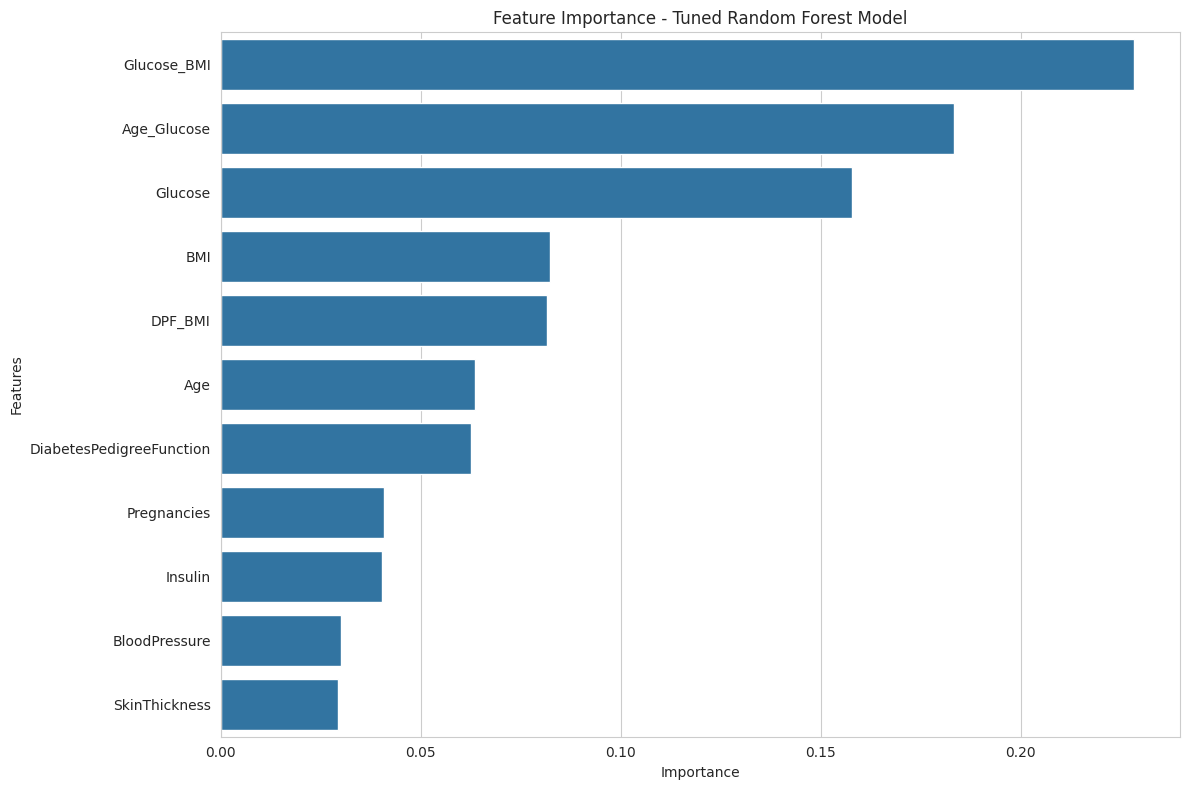

Feature Importance Ranking:
                     Feature  Importance
8                Glucose_BMI    0.228350
9                Age_Glucose    0.183203
1                    Glucose    0.157710
5                        BMI    0.082346
10                   DPF_BMI    0.081483
7                        Age    0.063537
6   DiabetesPedigreeFunction    0.062600
0                Pregnancies    0.040973
4                    Insulin    0.040276
2              BloodPressure    0.030119
3              SkinThickness    0.029403


<Figure size 1000x800 with 0 Axes>

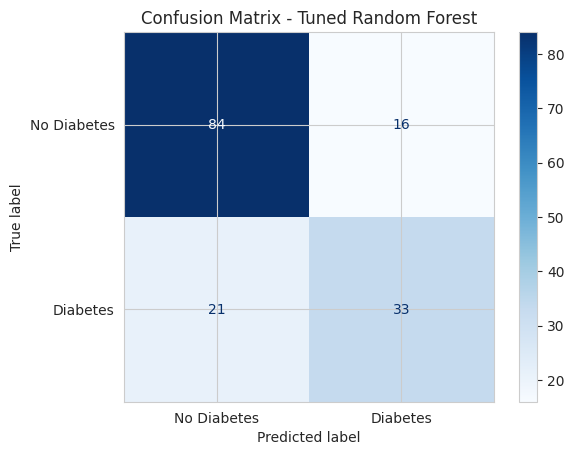

Specificity: 0.8400
Sensitivity (Recall): 0.6111
Precision: 0.6735
F1 Score: 0.6408


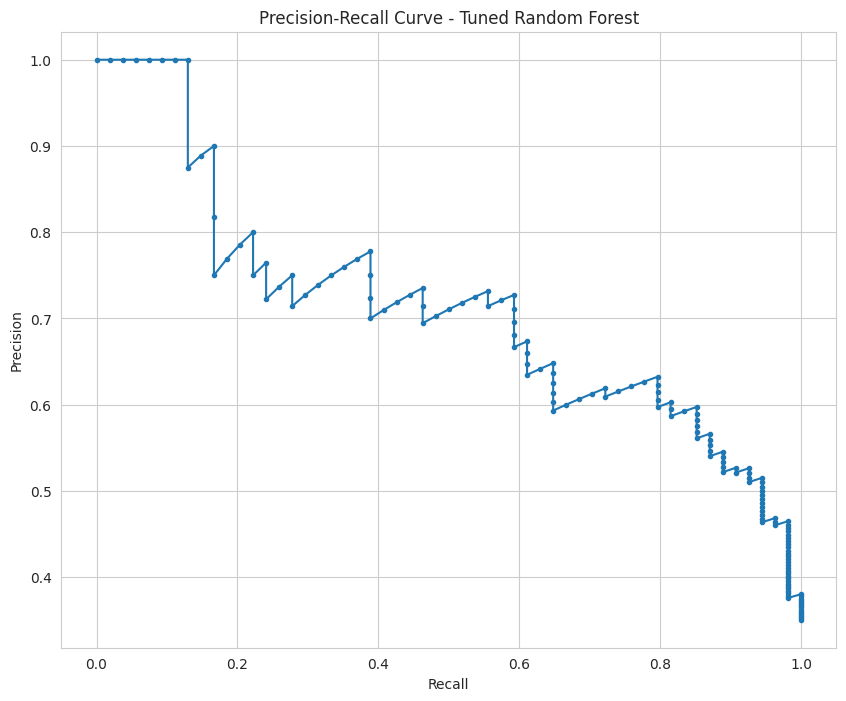


Optimal threshold for recall >= 0.7: 0.3569
Expected precision at this threshold: 0.6324
Expected recall at this threshold: 0.7963


<Figure size 1000x800 with 0 Axes>

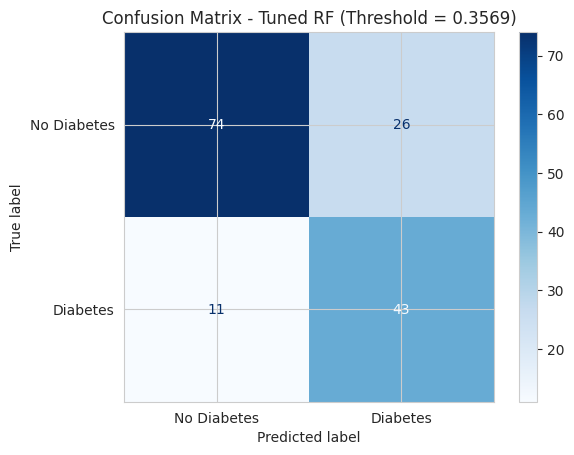


Performance with adjusted threshold:
Accuracy: 0.7597
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       100
           1       0.62      0.80      0.70        54

    accuracy                           0.76       154
   macro avg       0.75      0.77      0.75       154
weighted avg       0.78      0.76      0.76       154



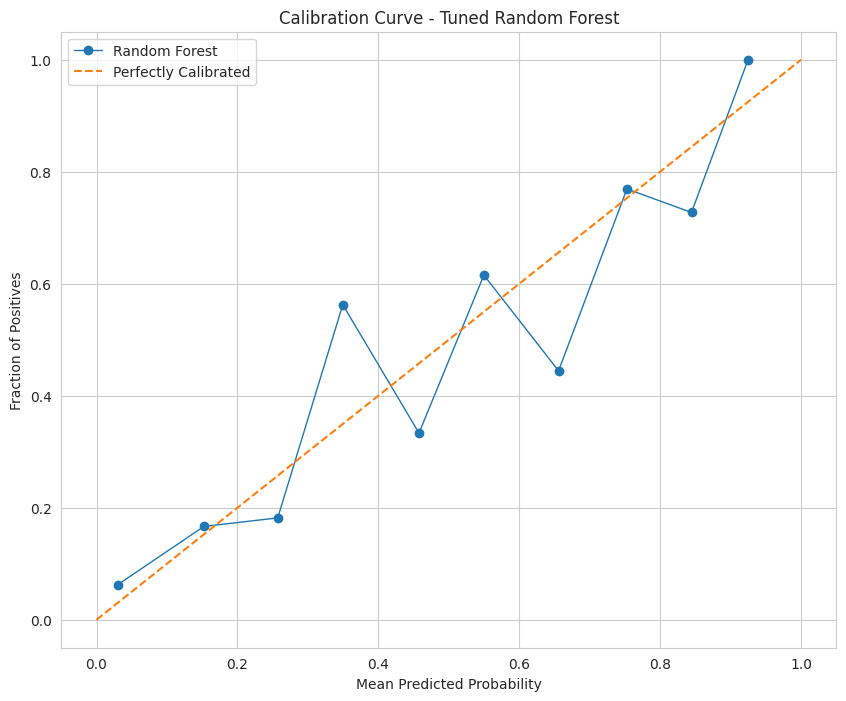


Sample Patient Prediction:
Diabetes probability: 0.6129
Prediction (default threshold): Diabetic
Prediction (optimized threshold): Diabetic

=== Final Diabetes Prediction Model Report ===
Best Model: Random Forest
Test Accuracy: 0.7597
Test AUC: 0.8263

Top 5 Most Important Features:
- Glucose_BMI: 0.2283
- Age_Glucose: 0.1832
- Glucose: 0.1577
- BMI: 0.0823
- DPF_BMI: 0.0815


In [10]:
# Extract the best models from tuning results
best_rf_model = tuned_models['Random Forest']['model']
best_gb_model = tuned_models['Gradient Boosting']['model']

# 1. Feature Importance Analysis for Random Forest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the tuned Random Forest
feature_importances = best_rf_model.feature_importances_
features = X.columns

# Create a DataFrame for easier visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - Tuned Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('tuned_rf_feature_importance.png')
plt.show()

print("Feature Importance Ranking:")
print(importance_df)

# 2. Confusion Matrix for the Best Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix for tuned Random Forest
y_pred_rf = best_rf_model.predict(X_test_scaled)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['No Diabetes', 'Diabetes'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Tuned Random Forest')
plt.savefig('tuned_rf_confusion_matrix.png')
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm_rf.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)  # same as recall
precision = tp / (tp + fp)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

print(f"Specificity: {specificity:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# 3. Threshold Adjustment to Improve Recall
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities for the positive class
y_probs_rf = best_rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate precision and recall for different thresholds
precision_values, recall_values, thresholds = precision_recall_curve(y_test, y_probs_rf)

# Create a DataFrame to examine thresholds
threshold_df = pd.DataFrame({
    'Threshold': [0] + list(thresholds),
    'Precision': list(precision_values),
    'Recall': list(recall_values)
})

# Plot precision-recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall_values, precision_values, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Tuned Random Forest')
plt.grid(True)
plt.savefig('precision_recall_curve.png')
plt.show()

# Find threshold for better recall (for example, targeting recall > 0.7)
target_recall = 0.7
valid_thresholds = threshold_df[threshold_df['Recall'] >= target_recall]

if not valid_thresholds.empty:
    # Get the threshold that maximizes precision while meeting recall target
    optimal_idx = valid_thresholds['Precision'].idxmax()
    optimal_threshold = valid_thresholds.loc[optimal_idx, 'Threshold']

    print(f"\nOptimal threshold for recall >= {target_recall}: {optimal_threshold:.4f}")
    print(f"Expected precision at this threshold: {valid_thresholds.loc[optimal_idx, 'Precision']:.4f}")
    print(f"Expected recall at this threshold: {valid_thresholds.loc[optimal_idx, 'Recall']:.4f}")

    # Apply the new threshold and evaluate
    y_pred_adjusted = (y_probs_rf >= optimal_threshold).astype(int)

    from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

    # Calculate performance metrics with the new threshold
    accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
    cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)

    # Plot confusion matrix with adjusted threshold
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=['No Diabetes', 'Diabetes'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix - Tuned RF (Threshold = {optimal_threshold:.4f})')
    plt.savefig('adjusted_threshold_confusion_matrix.png')
    plt.show()

    print("\nPerformance with adjusted threshold:")
    print(f"Accuracy: {accuracy_adjusted:.4f}")
    print(classification_report(y_test, y_pred_adjusted))
else:
    print(f"No threshold found that achieves recall >= {target_recall}")

# 4. Model Calibration Analysis
from sklearn.calibration import calibration_curve

# Plot calibration curve
plt.figure(figsize=(10, 8))
prob_true, prob_pred = calibration_curve(y_test, y_probs_rf, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve - Tuned Random Forest')
plt.legend()
plt.grid(True)
plt.savefig('calibration_curve.png')
plt.show()

# 5. Model Deployment Preparation

# Function for preprocessing new data
def preprocess_new_data(data):
    """
    Preprocess new data for prediction.

    Parameters:
    - data: DataFrame with the same features as the training data

    Returns:
    - Preprocessed data ready for prediction
    """
    # Handle zeros in features that shouldn't be zero
    for column in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
        if column in data.columns:
            # Use the same median values from training
            median_value = df_clean[df_clean[column] != 0][column].median()
            data[column] = data[column].replace(0, median_value)

    # Create the same engineered features if they were used in training
    if 'Glucose_BMI' in X.columns:
        data['Glucose_BMI'] = data['Glucose'] * data['BMI']

    if 'Age_Glucose' in X.columns:
        data['Age_Glucose'] = data['Age'] * data['Glucose']

    if 'DPF_BMI' in X.columns:
        data['DPF_BMI'] = data['DiabetesPedigreeFunction'] * data['BMI']

    # Scale the features using the same scaler
    scaled_data = scaler.transform(data)

    return scaled_data

# Function for making predictions with custom threshold
def predict_diabetes(data, threshold=0.5):
    """
    Predict diabetes using the tuned Random Forest model.

    Parameters:
    - data: DataFrame with patient data
    - threshold: Probability threshold for positive class (default: 0.5)

    Returns:
    - Predictions and probabilities
    """
    # Preprocess the data
    preprocessed_data = preprocess_new_data(data)

    # Get probabilities
    probabilities = best_rf_model.predict_proba(preprocessed_data)[:, 1]

    # Make predictions using the custom threshold
    predictions = (probabilities >= threshold).astype(int)

    return predictions, probabilities

# 6. Save the model for future use
import joblib

# Save the model, scaler, and preprocessing information
model_info = {
    'model': best_rf_model,
    'scaler': scaler,
    'feature_names': X.columns.tolist(),
    'feature_medians': {col: df_clean[df_clean[col] != 0][col].median()
                        for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']},
    'threshold': optimal_threshold if 'optimal_threshold' in locals() else 0.5,
    'performance_metrics': {
        'accuracy': tuned_models['Random Forest']['test_accuracy'],
        'precision': tuned_models['Random Forest']['test_precision'],
        'recall': tuned_models['Random Forest']['test_recall'],
        'f1': tuned_models['Random Forest']['test_f1'],
        'auc': tuned_models['Random Forest']['test_auc']
    }
}

joblib.dump(model_info, 'diabetes_prediction_model.pkl')

# 7. Example of making predictions with new data
# (This would typically be in a separate script that loads the saved model)

# Example of loading the model
# loaded_model_info = joblib.load('diabetes_prediction_model.pkl')
# best_model = loaded_model_info['model']
# scaler = loaded_model_info['scaler']
# threshold = loaded_model_info['threshold']

# Sample data for prediction (hypothetical patient)
sample_patient = pd.DataFrame({
    'Pregnancies': [2],
    'Glucose': [140],
    'BloodPressure': [90],
    'SkinThickness': [30],
    'Insulin': [150],
    'BMI': [32.1],
    'DiabetesPedigreeFunction': [0.6],
    'Age': [45]
})

if 'Glucose_BMI' in X.columns:
    sample_patient['Glucose_BMI'] = sample_patient['Glucose'] * sample_patient['BMI']
if 'Age_Glucose' in X.columns:
    sample_patient['Age_Glucose'] = sample_patient['Age'] * sample_patient['Glucose']
if 'DPF_BMI' in X.columns:
    sample_patient['DPF_BMI'] = sample_patient['DiabetesPedigreeFunction'] * sample_patient['BMI']

# Predict using default threshold
prediction, probability = predict_diabetes(sample_patient)
print("\nSample Patient Prediction:")
print(f"Diabetes probability: {probability[0]:.4f}")
print(f"Prediction (default threshold): {'Diabetic' if prediction[0] == 1 else 'Not Diabetic'}")

# Predict using optimized threshold (if available)
if 'optimal_threshold' in locals():
    prediction, _ = predict_diabetes(sample_patient, threshold=optimal_threshold)
    print(f"Prediction (optimized threshold): {'Diabetic' if prediction[0] == 1 else 'Not Diabetic'}")

# 8. Final Conclusion and Insights
print("\n=== Final Diabetes Prediction Model Report ===")
print(f"Best Model: Random Forest")
print(f"Test Accuracy: {tuned_models['Random Forest']['test_accuracy']:.4f}")
print(f"Test AUC: {tuned_models['Random Forest']['test_auc']:.4f}")
print("\nTop 5 Most Important Features:")
for i, row in importance_df.head(5).iterrows():
    print(f"- {row['Feature']}: {row['Importance']:.4f}")
